# Notebook to develop HMM model to investigate optimal angle selection

## Defining the targets we will be using in our multiaspect classification model

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec

from scipy.special import spherical_jn, spherical_yn

import ipywidgets as widgets
from IPython.display import display

from sklearn.cluster import KMeans
import seaborn as sns
import pandas as pd

## Below is the analytical DWBA solution for a prolate spheroid geometry

In [47]:
def dwba_prolate_spheroid(L, a, g, h, ka, phi):
    """
    DWBA solution for a fluid prolate spheroid.
    Lee, W.-J., Lavery, A. C., and Stanton, T. K. (2012). 
    “Orientation dependence of broadband acoustic backscattering from live squid,” 
    The Journal of the Acoustical Society of America, 131, 4461–4475. doi:10.1121/1.3701876
    
    Parameters
    ----------
    L : float
        Length of spheroid (long axis) [m]
    a : float
        Radius of spheroid (short axis) [m]
    g : float
        Density contrast (rho2/rho1)
    h : float
        Sound speed contrast (c2/c1)
    ka : array_like
        Dimensionless ka (wavenumber * radius)
    phi : float or array_like
        Incident angle [radians]

    Returns
    -------
    fbs : array_like
        Complex backscattering amplitude
    """
    # Convert inputs to arrays and ensure proper broadcasting
    ka = np.atleast_1d(ka)
    phi = np.atleast_1d(phi)

    # Calculate contrast term
    contrast = 1/(g * h**2) + 1/g - 2
    
    # Convert incident angle to beta
    beta = phi[..., np.newaxis] + np.pi / 2  # Add dimension for broadcasting with ka
    # beta = phi + np.pi/2
    
    # Calculate aspect ratio term (L/2a)
    aspect_ratio = L / (2 * a)

    # Calculate argument for Bessel function
    ellip_term = np.sqrt(np.sin(beta)**2 + (aspect_ratio**2) * np.cos(beta)**2)
    bessel_arg = 2 * ka / h * ellip_term
    
    # Calculate spherical Bessel function
    j1 = spherical_jn(1, bessel_arg)
    
    # Calculate final backscattering amplitude
    fbs = (ka**2) * L * contrast/2 * j1/bessel_arg

    return fbs.squeeze()

## Defining the measurement and target constants

In [48]:
a = 0.15 # semi-minor axis (equatorial radius)
g = 1.043 # density contrast
h = 1.053 # sound speed contrast
c = 1500 # speed of sound in water

freq_lowerbound = 100 # frequency response lower bound
freq_upperbound = 30e3 # frequency response upper bound
freq = np.arange(freq_lowerbound, freq_upperbound, 10)
k = 2*np.pi*freq / c # acoustic wavenumber (phase shift per meter)
ka = k*a

## Define constants that come before any testing trial has started

In [49]:
# CONSTANTS RELATING TO MAX ITERATIONS 
max_iter = 10
t = 0

# CONSTANTS DEFINING DETECTION CONFIDENCE AND AGENT OPTIONS
cumulative_log_likelihood = 0
cumulative_log_likelihoods = np.full(max_iter+1, np.nan)
cumulative_log_likelihoods[0] = cumulative_log_likelihood
candidate_angle_steps = np.array([-5, 5])

## DEFINE STATE CENTERS
state_angle_step = 5
last_state = 90
first_state = -90
state_centers = np.arange(-last_state, last_state, state_angle_step) + (state_angle_step / 2)
alpha_states_for_received_code = np.zeros((max_iter+1, state_centers.shape[0]))

# BUILD TRAINING DATASET USING DISTORED WAVE BORN APPROXIMATION FROM PROLATE SPHEROID OF ASPECT RATIO = 1
trained_target_AR = 1.5

measurement_angle_step = 0.5
angle_all = np.arange(first_state, last_state+measurement_angle_step, measurement_angle_step)
L = trained_target_AR * 2*a
phi_all = np.deg2rad(angle_all)
fbs_full = dwba_prolate_spheroid(L, a, g, h, ka, phi_all)
TS_standard = 20*np.log10(np.abs(fbs_full))

# PERFORM VECTOR QUANTIZATION ON WAVEFORMS MEASURED FROM TRAINING TARGET TO BUILD CODEBOOK
k = TS_standard.shape[0]//45
state = 1500
kmean_TS_codebook = KMeans(n_clusters=k, n_init=10, random_state=state).fit(TS_standard)
labels = kmean_TS_codebook.labels_

## DEVELOP EMISSION MATRIX FOR TRAINED MODEL
emission_matrix_B = np.zeros((state_centers.shape[0], kmean_TS_codebook.n_clusters))
for i, state_center in enumerate(state_centers):
    angle_indices_for_state = np.where((state_center-(state_angle_step/2)<=angle_all)&(angle_all<state_center+(state_angle_step/2)))[0]
    TS_state_target_k = TS_standard[angle_indices_for_state,:]
    target_k_state_cluster_preds = kmean_TS_codebook.predict(TS_state_target_k)

    density, clusters = np.histogram(target_k_state_cluster_preds, bins=np.arange(0, kmean_TS_codebook.n_clusters+1), density=True)
    emission_matrix_B[i, :] = density
assert np.isclose(emission_matrix_B.sum(axis=1), np.ones(state_centers.shape[0])).all()

## DEFINE (UNKNOWN) INITIAL STATE AND (KNOWN) PROBABILITY OF BEING IN ANY INITIAL STATE
initial_state_prob = state_angle_step / (last_state - first_state)
current_state = 0
true_target_AR = 2.5
true_target_L = true_target_AR * 2*a

In [50]:
measurement_angle_step = 0.5
angle_all = np.arange(-90, 90+measurement_angle_step, measurement_angle_step)

def update_dwba_for_ellipse(angle, aspect_ratio):
    L = aspect_ratio*2*a

    # TS across all angles
    phi_all = np.deg2rad(angle_all)
    fbs_full = dwba_prolate_spheroid(L, a, g, h, ka, phi_all)
    TS_all = 20*np.log10(np.abs(fbs_full))

    phi = np.deg2rad(angle)
    fbs = dwba_prolate_spheroid(L, a, g, h, ka, phi)
    TS = 20*np.log10(np.abs(fbs))

    # Define ellipse parameters
    width = 2*a  # width
    height = L  # height
    ellipse_angle = 90 - angle # rotation angle [deg]

    # Create the ellipse patch
    ellipse = patches.Ellipse(
        (0.5, -0.5), width, height, angle=ellipse_angle, 
        facecolor='lightblue', edgecolor='blue')

    fig = plt.figure(figsize=(7,6))
    gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1])
    fig.subplots_adjust(hspace=0.1)

    # All angles
    ax0 = fig.add_subplot(gs[0,0])
    ax0.imshow(TS_all, aspect="auto", vmax=-25, vmin=-80,
                extent=(0, freq_upperbound//1e3, -90, 90+measurement_angle_step))
    ax0.set_yticks(np.arange(-90, 90+measurement_angle_step, 30))
    ax0.set_ylabel("Incident angle (°)", fontsize=12)
    ax0.set_xlim(freq_lowerbound, freq_upperbound)
    received_code = kmean_TS_codebook.predict(TS.reshape((1, freq.shape[0])))[0]
    ax0.axhline(angle, color="magenta", label=f'Code={received_code}, Likelihood={(initial_state_prob*emission_matrix_B[:,received_code]).sum():.3f}')
    ax0.legend()

    # One angle slice
    ax1 = fig.add_subplot(gs[1,0], sharex=ax0)
    ax1.plot(freq/1e3, TS, lw=0.75)
    ax1.set_xlim(freq_lowerbound/1e3, freq_upperbound/1e3)
    ax1.set_ylim(-90, -20)
    ax1.set_xlabel("Frequency (kHz)", fontsize=12)
    ax1.set_ylabel("TS (dB)", fontsize=12)

    # Ellipse (cross section of prolate spheroid)
    ax_ellip = fig.add_subplot(gs[1,1])
    ax_ellip.add_patch(ellipse)
    ax_ellip.annotate("Incident sound", xytext=(0.5, -1.5), xy=(0.5, -0.95),
        arrowprops=dict(arrowstyle="->,head_length=0.5,head_width=0.3",
                        linewidth=2),
        fontsize=12,
        ha="center")
    ax_ellip.set_aspect('equal', adjustable='box')
    ax_ellip.axis('off')
    ax_ellip.set_xlim(0, 1)
    ax_ellip.set_ylim(-1.5, 0)

    ax0.set_title("TS of a fluid prolate spheroid")
    plt.tight_layout()
    plt.show()

## Plotting the acoustic color of example targets for my own viewing

In [51]:
aa = np.arange(-90, 91, 1)
angle_slider = widgets.SelectionSlider(
    options=aa,
    value=0,  # default value
    description="Incident angle (°)",
    style={'description_width': 'initial'},
    continuous_update=True,
    layout=widgets.Layout(width="400px"),
)

aspect_ratio_slider = widgets.FloatSlider(
    value=2.0, 
    min=0.1, 
    max=2, 
    step=0.1, 
    description="Aspect ratio", 
    continuous_update=True, 
    style={'description_width': 'initial'}, 
    layout=widgets.Layout(width="400px")
)
interactive_plot = widgets.interactive(
    update_dwba_for_ellipse, angle=angle_slider, aspect_ratio=aspect_ratio_slider)
display(interactive_plot)

interactive(children=(SelectionSlider(description='Incident angle (°)', index=90, layout=Layout(width='400px')…

In [52]:
def w_(theta):
    sigma_i = state_angle_step / 2
    normalization = 1 / np.sqrt(2*np.pi*(sigma_i**2))

    return normalization * np.exp(-0.5*((theta/sigma_i)**2))

def state_transition_model(delta_angle):
    angular_dist_between_states = (state_centers[np.newaxis, :] - state_centers[:, np.newaxis])

    return w_(angular_dist_between_states - delta_angle)

## Below we run a single trial up to some max_iter iterations

/Users/adityakrishna/.local/share/mamba/envs/muri-info/lib/python3.13/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


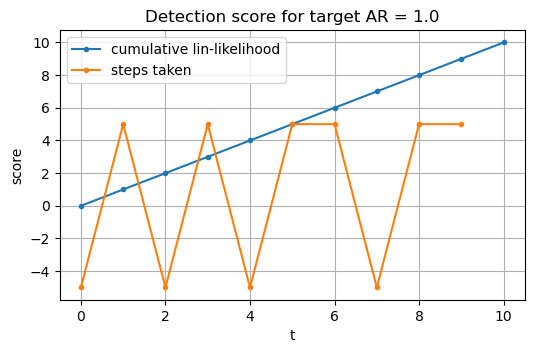

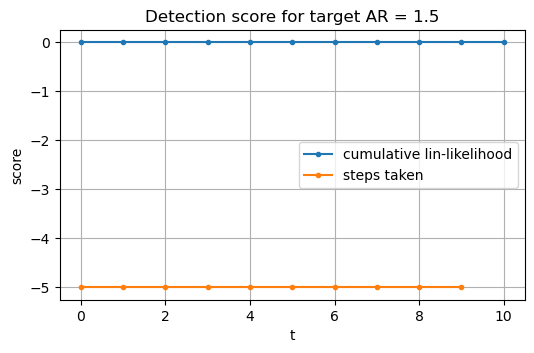

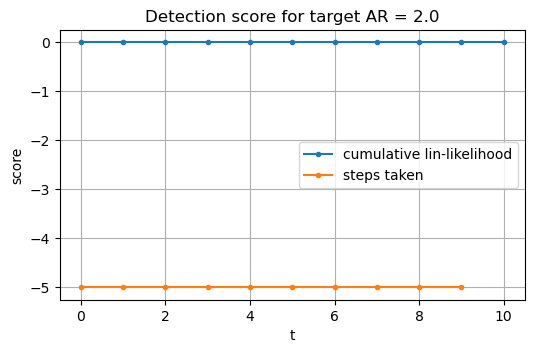

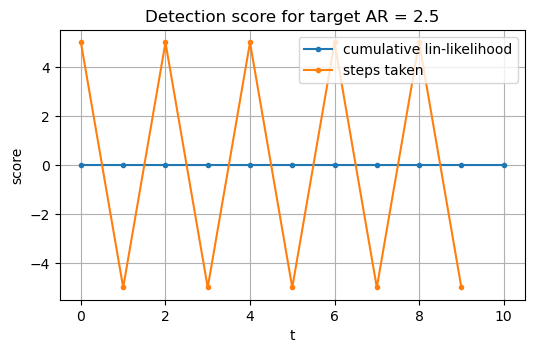

In [60]:
# CONSTANTS RELATING TO MAX ITERATIONS 
max_iter = 10

candidate_angle_steps = np.array([-5, 5])

## DEFINE STATE CENTERS
state_angle_step = 5
last_state = 90
first_state = -90
state_centers = np.arange(-last_state, last_state, state_angle_step) + (state_angle_step / 2)
alpha_states_for_received_code = np.zeros((max_iter+1, state_centers.shape[0]))
angle_steps_taken = np.full(max_iter+1, np.nan)

# BUILD TRAINING DATASET USING DISTORED WAVE BORN APPROXIMATION FROM PROLATE SPHEROID OF ASPECT RATIO = 1
trained_target_AR = 1.0

current_state = 0
measurement_angle_step = 0.5
angle_all = np.arange(first_state, last_state+measurement_angle_step, measurement_angle_step)
L = trained_target_AR * 2*a
phi_all = np.deg2rad(angle_all)
fbs_full = dwba_prolate_spheroid(L, a, g, h, ka, phi_all)
TS_standard = 20*np.log10(np.abs(fbs_full))

# PERFORM VECTOR QUANTIZATION ON WAVEFORMS MEASURED FROM TRAINING TARGET TO BUILD CODEBOOK
k = TS_standard.shape[0]//45
state = 1500
kmean_TS_codebook = KMeans(n_clusters=k, n_init=10, random_state=state).fit(TS_standard)
labels = kmean_TS_codebook.labels_

## DEVELOP EMISSION MATRIX FOR TRAINED MODEL
emission_matrix_B = np.zeros((state_centers.shape[0], kmean_TS_codebook.n_clusters))
for i, state_center in enumerate(state_centers):
    angle_indices_for_state = np.where((state_center-(state_angle_step/2)<=angle_all)&(angle_all<state_center+(state_angle_step/2)))[0]
    TS_state_target_k = TS_standard[angle_indices_for_state,:]
    target_k_state_cluster_preds = kmean_TS_codebook.predict(TS_state_target_k)

    density, clusters = np.histogram(target_k_state_cluster_preds, bins=np.arange(0, kmean_TS_codebook.n_clusters+1), density=True)
    emission_matrix_B[i, :] = density
assert np.isclose(emission_matrix_B.sum(axis=1), np.ones(state_centers.shape[0])).all()

## DEFINE (UNKNOWN) INITIAL STATE AND (KNOWN) PROBABILITY OF BEING IN ANY INITIAL STATE
initial_state_prob = state_angle_step / (last_state - first_state)

for true_target_AR in np.arange(1.0, 3.0, 0.5):
    true_target_L = true_target_AR * 2*a

    t = 0
    # CONSTANTS DEFINING DETECTION CONFIDENCE AND AGENT OPTIONS
    cumulative_log_likelihood = 0
    cumulative_log_likelihoods = np.full(max_iter+1, np.nan)
    cumulative_log_likelihoods[0] = cumulative_log_likelihood

    cumulative_lin_likelihood = 0
    cumulative_lin_likelihoods = np.full(max_iter+1, np.nan)
    cumulative_lin_likelihoods[0] = cumulative_lin_likelihood

    while t < max_iter:
        # print(f'############### ITERATION t={t} ###############\nCurrently in state containing: {current_state}')
        ## GENERATE RECEIVED WAVEFORM AND OBSERVATION FROM CURRENT INITIAL STATE
        phi = np.deg2rad(current_state)
        fbs = dwba_prolate_spheroid(true_target_L, a, g, h, ka, phi)
        received_TS = 20*np.log10(np.abs(fbs))
        received_code = kmean_TS_codebook.predict(received_TS.reshape((1, freq.shape[0])))[0]

        ## COMPUTE LIKELIHOOD OF RECEIVING OBSERVATION USING EMISSION MATRIX
        if t == 0:
            alpha_bar = initial_state_prob * emission_matrix_B[:, received_code]   # unnormalized
            ct = alpha_bar.sum()
            cumulative_lin_likelihood += (max(ct, 1e-12))
            cumulative_log_likelihood += np.log10(max(ct, 1e-12))
            alpha_states_for_received_code[t, :] = alpha_bar
        elif t >= 1:        
            m = alpha_states_for_received_code[t-1, :] @ A_step              # predict
            alpha_bar = m * emission_matrix_B[:, received_code]              # update (unnormalized)
            ct = alpha_bar.sum()                                             # p(o_t | history, action)
            cumulative_lin_likelihood += (max(ct, 1e-12))
            cumulative_log_likelihood += np.log10(max(ct, 1e-12))
            alpha_states_for_received_code[t, :] = alpha_bar

        assert(alpha_states_for_received_code[t,:].shape[0] == state_centers.shape[0])
        # RECORD LIKELIHOOD OF THE SCORE
        # Show the true per-step increment: log10(c_t) (or c1 at t=0)
        log_likelihood_of_received_code = np.log10(max(ct, 1e-12))
        # print(f"Received {received_code}, log likelihood = {log_likelihood_of_received_code}")

        cumulative_lin_likelihoods[t+1] = cumulative_lin_likelihood
        cumulative_log_likelihoods[t+1] = cumulative_log_likelihood

        # DECISION THRESHOLD τ
        tau = -100
        decision = (cumulative_log_likelihood <= tau)  # True => declare target present
        # print(f"t={t}  cumulative_log_likelihood={cumulative_log_likelihood:.3f}  cumulative_lin_likelihood={cumulative_lin_likelihood:.3f}  decision={decision}  (tau={tau})")

        # FIND EXPECTED LOG LIKELIHOOD FOR EACH CANDIDATE ANGLE STEP TO DETERMINE OPTIMAL STEP TO TAKE
        step = 5
        ccw = -step
        cw = step
        if (current_state == 90):
            candidate_angle_steps = np.array([ccw])
        elif (current_state == -90):
            candidate_angle_steps = np.array([cw])
        else: 
            candidate_angle_steps = np.array([ccw, cw])
        forecasted_expected_log_likelihood_per_trial = np.zeros(candidate_angle_steps.shape[0])
        for a_step, candidate_angle_step in enumerate(candidate_angle_steps):
            A_step_candidate = state_transition_model(candidate_angle_step)
            A_step_candidate = A_step_candidate / A_step_candidate.sum(axis=1, keepdims=True)

            m_pred = alpha_states_for_received_code[t, :] @ A_step_candidate 
            q = m_pred @ emission_matrix_B                                    
            q = np.clip(q, 1e-12, None)  # avoid log(0) without renormalizing B
            J = (q * np.log10(q)).sum()  # expected next-step log-likelihood (base-10)

            forecasted_expected_log_likelihood_per_trial[a_step] = J

        # SELECT OPTIMAL ANGLE STEP TO TAKE BASED ON MAXIMIZING EXPECTED LOG LIKELIHOOD
        angle_step_to_make = candidate_angle_steps[(forecasted_expected_log_likelihood_per_trial).argmax()]
        angle_steps_taken[t] = angle_step_to_make
        current_state = (current_state + angle_step_to_make)
        A_step = state_transition_model(angle_step_to_make)
        A_step = A_step / A_step.sum(axis=1, keepdims=True)

        # print(f'Moving to: {current_state}, based on {forecasted_expected_log_likelihood_per_trial} for {candidate_angle_steps}')
        t+=1

    plt.figure(figsize=(6,3.5))
    plt.plot(cumulative_lin_likelihoods, marker='.', label='cumulative lin-likelihood')
    plt.plot(angle_steps_taken, marker='.', label='steps taken')
    plt.xlabel('t')
    plt.ylabel('score')
    plt.title(f'Detection score for target AR = {true_target_AR:.1f}')
    plt.grid(True, which='both')
    plt.legend()
    plt.show()